## Exploratory Data Analysis: Predicting Obesity Levels from Lifestyle and Demographics

In this notebook, we explore a dataset containing demographic, behavioral, and lifestyle information to understand the factors associated with obesity levels.

Our goal is to perform a structured exploratory data analysis (EDA) to:
- Understand the structure and types of variables in the dataset
- Visualize the distribution of both numerical and categorical features
- Investigate the relationship between features and the target variable (`obesity_level`)
- Identify statistically significant associations using correlation analysis and chi-squared tests
- Highlight promising features for predictive modeling

This EDA will help guide feature selection and modeling strategies for predicting obesity categories.

In [2]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Load feather file
df = pd.read_feather("../processed_data/obesity_cleaned.feather")

# Quick check of all variables
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype   
---  ------                     --------------  -----   
 0   gender                     2111 non-null   category
 1   age                        2111 non-null   float64 
 2   height_m                   2111 non-null   float64 
 3   weight_kg                  2111 non-null   float64 
 4   family_history_overweight  2111 non-null   category
 5   high_caloric_food_freq     2111 non-null   category
 6   vegetables_freq            2111 non-null   category
 7   main_meal_count            2111 non-null   category
 8   snacking_freq              2111 non-null   category
 9   smokes                     2111 non-null   category
 10  water_intake               2111 non-null   category
 11  calorie_tracking           2111 non-null   category
 12  physical_activity_freq     2111 non-null   category
 13  screen_time_hours          2111 n

## Summary Statistics and Feature Distributions

We start our analysis by reviewing descriptive statistics of the numerical features and plotting the distributions of categorical variables.

- **Numerical summary** helps us understand central tendencies and ranges, and flag potential outliers.
- **Categorical distributions** reveal class imbalances, dominant levels, and rare categories that may require preprocessing before modeling.

In [ ]:
# Summary statistics for numerical variables
df.describe()

,age,height_m,weight_kg
count,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058
std,6.345968,0.093305,26.191172
min,14.000000,1.450000,39.000000
25%,19.947192,1.630000,65.473343
50%,22.777890,1.700499,83.000000
75%,26.000000,1.768464,107.430682
max,61.000000,1.980000,173.000000


### Distribution of Numerical Features

We plot the distribution of numerical features to detect skewness, outliers, and potential groupings:


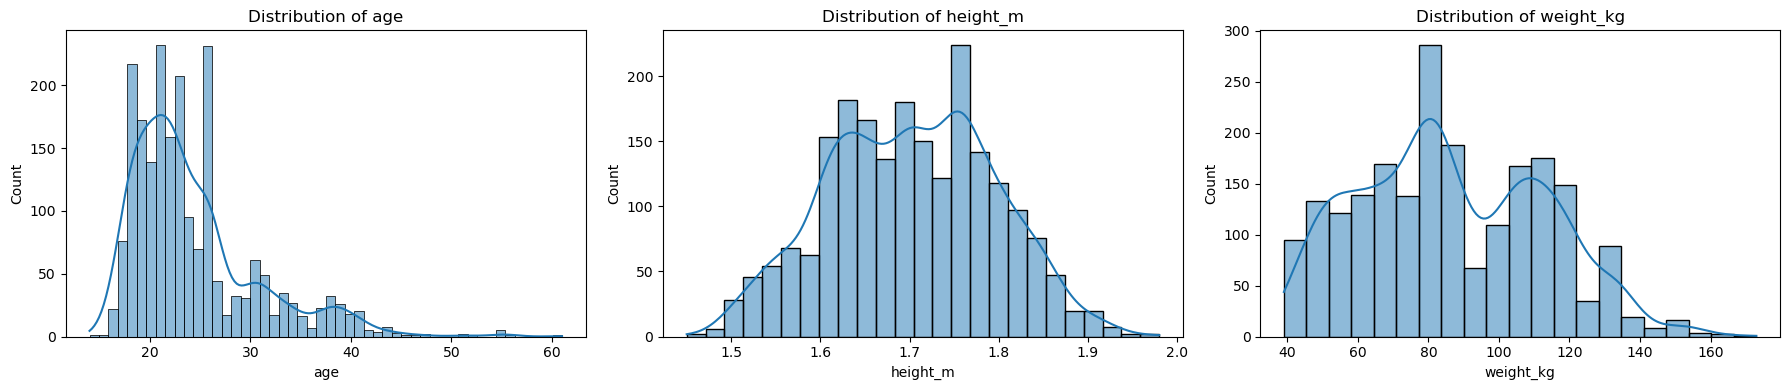

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include='float').columns
n_cols = 3  # number of plots per row
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- **Age** is right-skewed, with most individuals in their late teens to late twenties. A small number of older individuals may warrant age grouping or transformation.
- **Height** appears normally distributed, with no strong outliers.
- **Weight** shows a bimodal pattern, indicating distinct groups that likely align with obesity levels. This confirms its expected importance as a predictor in classification models.

### Numerical Features by Obesity Level

We use boxplots to explore how numerical features vary across the obesity categories.

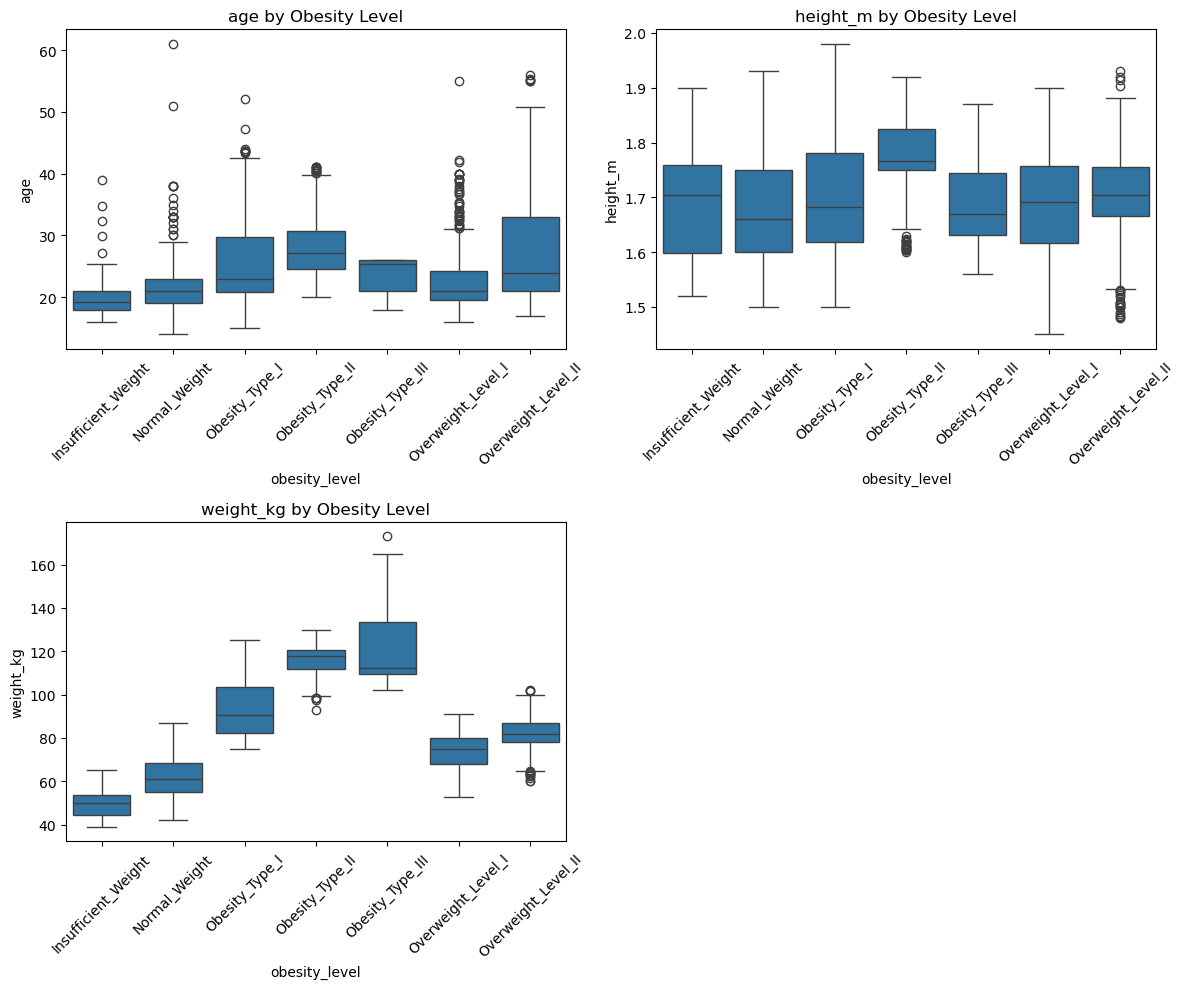

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

num_cols = df.select_dtypes(include='float').columns
n_cols = 2  # number of plots per row
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.boxplot(data=df, x='obesity_level', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Obesity Level')
    axes[i].tick_params(axis='x', rotation=45)

# Hide unused plots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- **Weight** is strongly associated with obesity levels. As expected, individuals in higher obesity classes tend to weigh significantly more. This supports weight as a key predictive variable.
- **Height** varies very little across obesity categories, suggesting it may contribute little on its own.
- **Age** shows mild variation across groups, with slightly older individuals appearing more often in higher obesity levels. However, the overlap indicates age may be a secondary predictor at best.

### Categorical Feature Distributions

We visualize the frequency of each category in the dataset. This reveals important data characteristics:

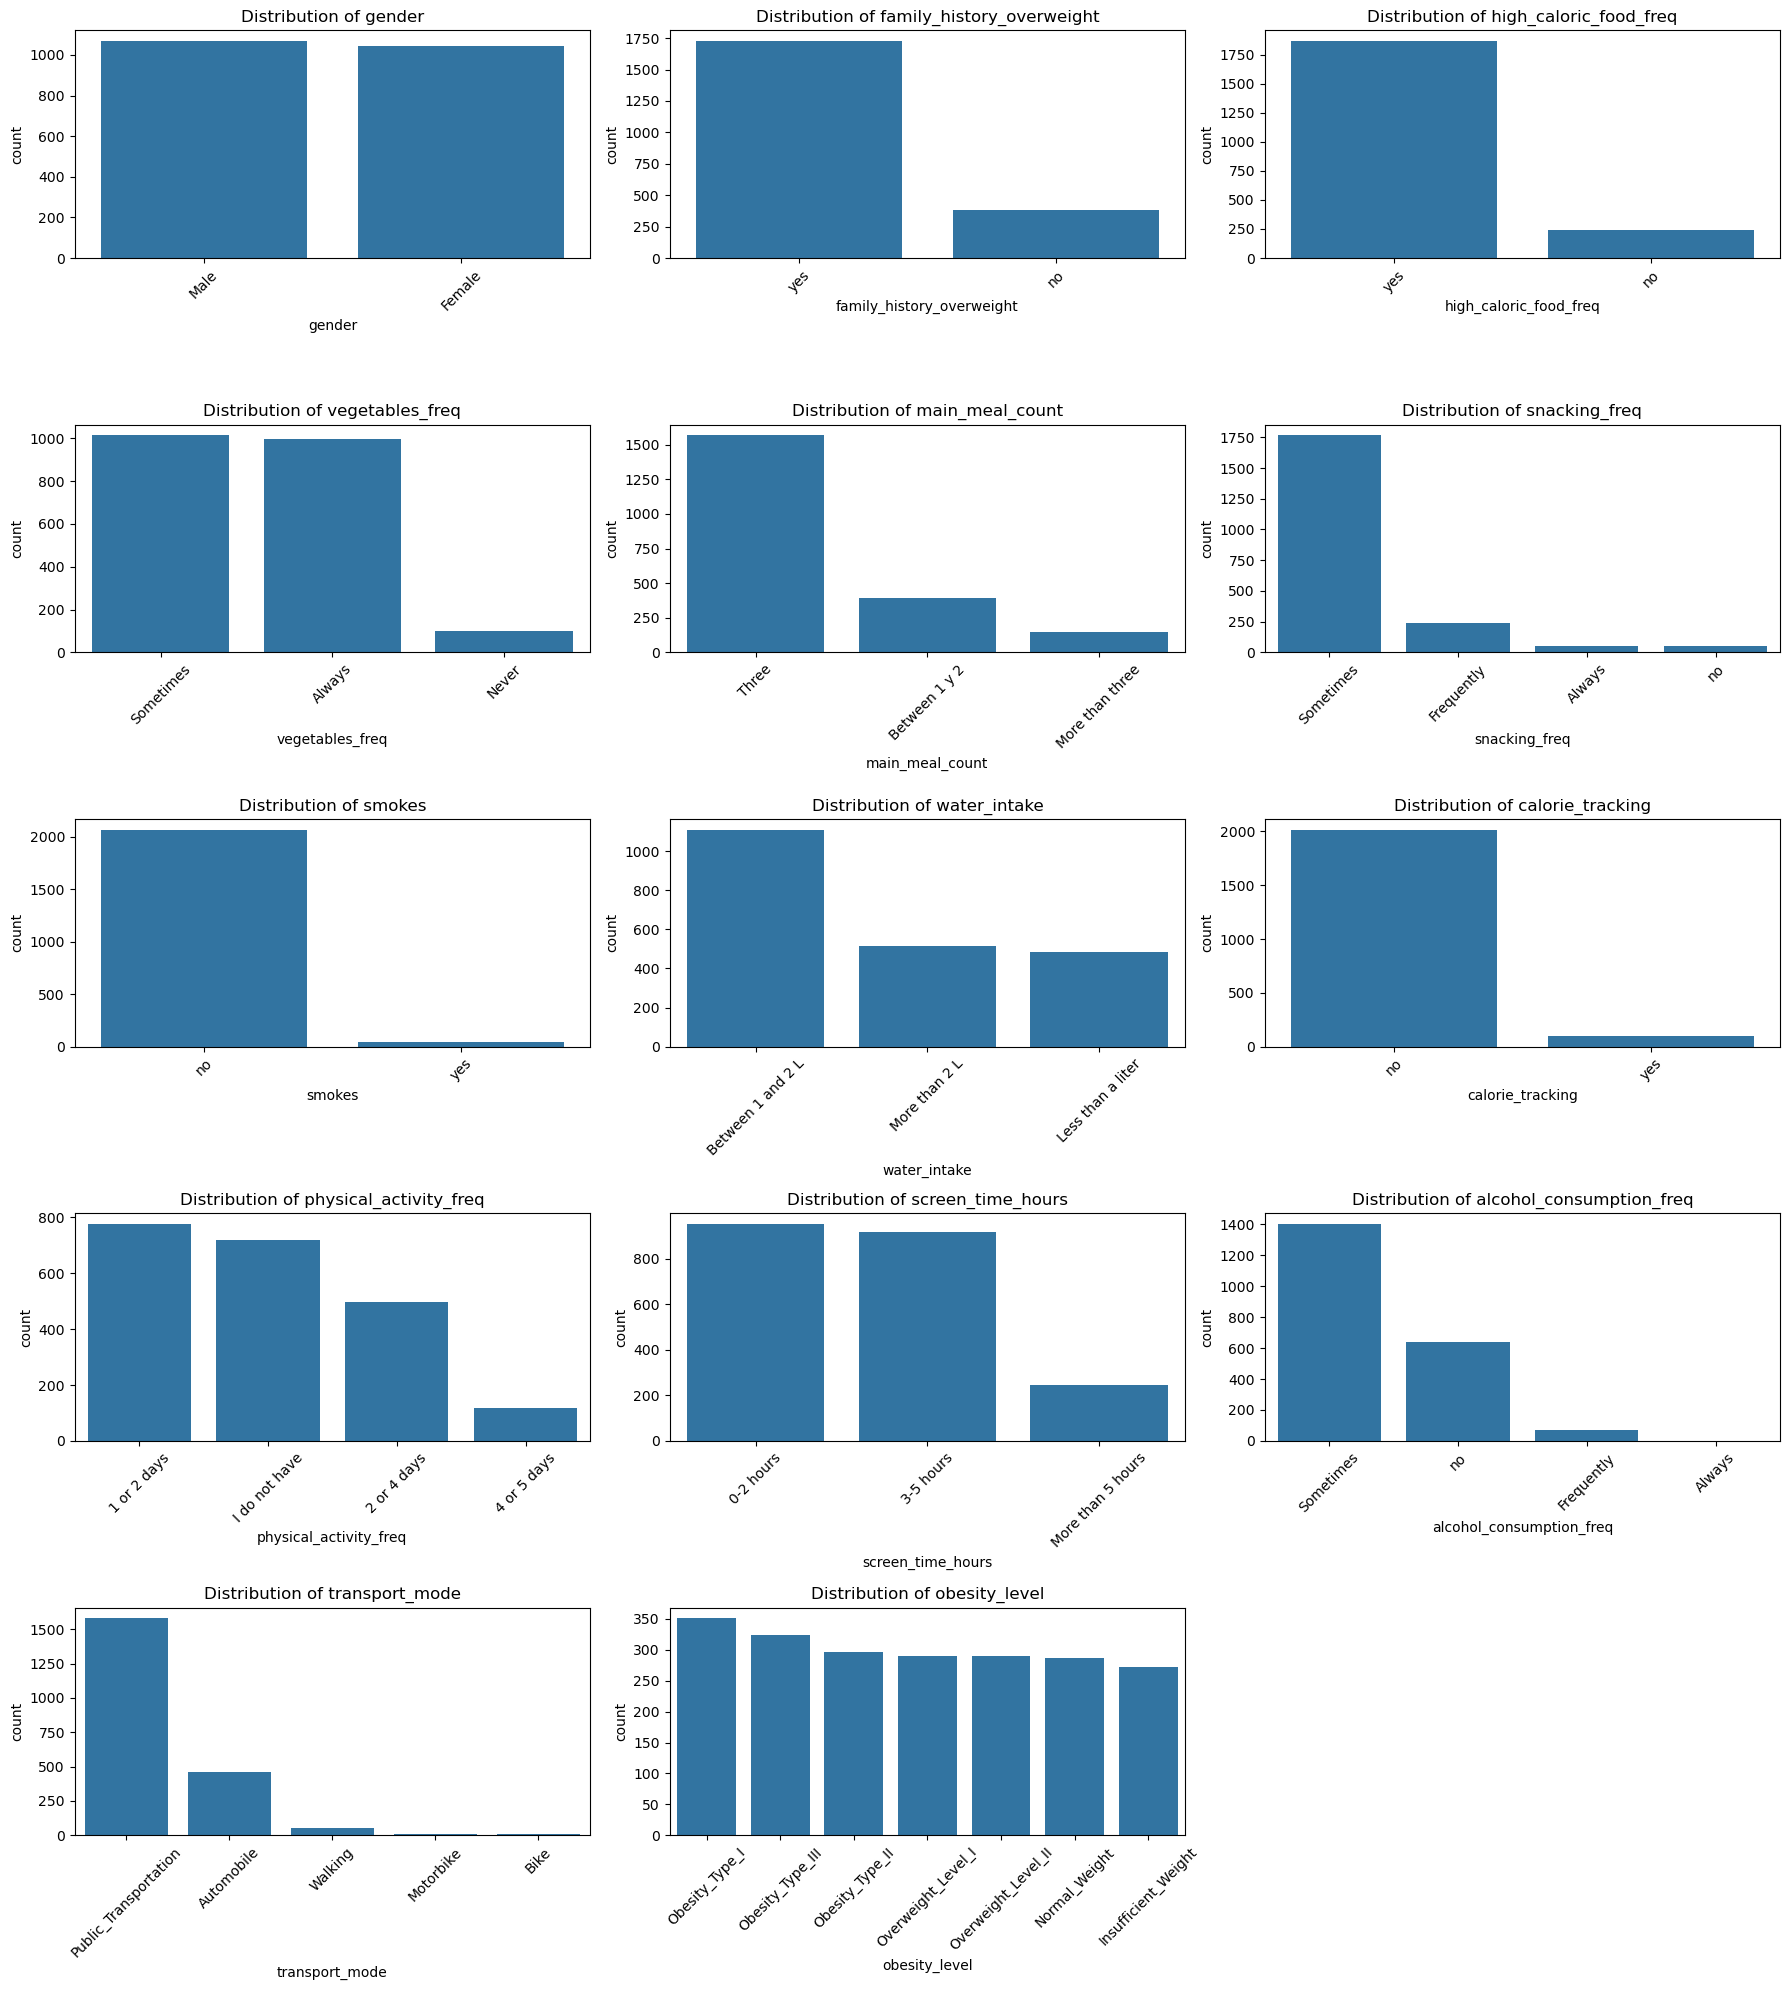

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_cols = df.select_dtypes(include='category').columns
n_cols = 3  # number of plots per row
n_rows = (len(cat_cols) + n_cols - 1) // n_cols  # ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

axes = axes.flatten()  # make 1D so we can iterate easily

for i, col in enumerate(cat_cols):
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


- Some variables, such as `smokes` and `calorie_tracking`, are highly imbalanced, which may require grouping or careful modeling.
- Lifestyle variables such as `vegetables_freq`, `physical_activity_freq`, and `screen_time_hours` show greater diversity, suggesting they may carry more signal for predicting obesity levels.
- The target variable `obesity_level` appears reasonably balanced across categories, which reduces the need for special handling like resampling or weighting.

### Correlation with Obesity Levels

To better understand which features are most predictive of obesity level, we computed the Pearson correlation between one-hot encoded features and each obesity class.

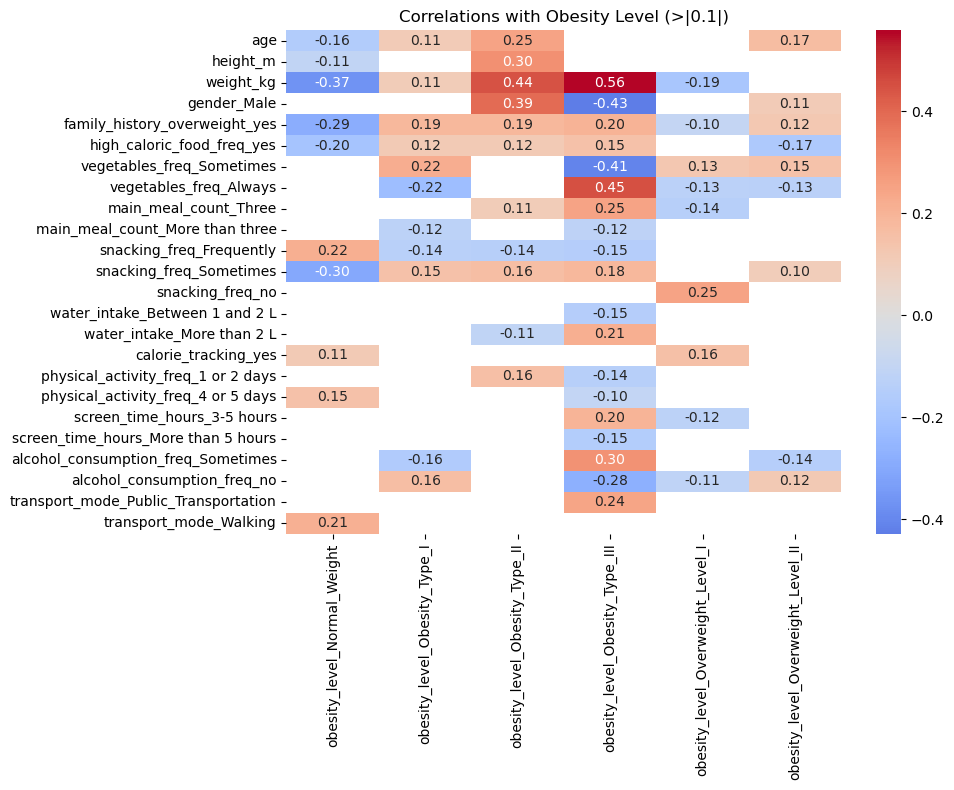

In [28]:
# One-hot encode
df_encoded = pd.get_dummies(df, drop_first=True)

# Compute full correlation matrix
corr = df_encoded.corr()

# Select only target columns (those that start with 'obesity_level_')
target_cols = [col for col in corr.columns if col.startswith('obesity_level_')]

# Extract only correlations between features and the target columns
target_corr = corr[target_cols].drop(index=target_cols)

# Filter by threshold
threshold = 0.1
strong_target_corr = target_corr[(target_corr > threshold) | (target_corr < -threshold)].dropna(how='all')

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(strong_target_corr, cmap='coolwarm', center=0, annot=True, fmt=".2f")
plt.title("Correlations with Obesity Level (>|0.1|)")
plt.tight_layout()
plt.show()


- **Weight is the most predictive feature**, showing strong positive correlation with `Obesity_Type_I` and `Obesity_Type_II`, and negative with `Normal_Weight`.
- **Gender** and **vegetable intake** also show clear directional patterns across obesity levels.
- Other lifestyle variables (e.g., snacking frequency, screen time, water intake) have weaker but consistent correlations, suggesting they may be more useful in combination than alone.
- These correlations support the idea that obesity is influenced by a mix of **biological**, **behavioral**, and **environmental** factors.